# 8. Systematic uncertainties

In this exercise, we will analyse the data of PKS 2155-304 from the H.E.S.S. DL3-DR1, compute its average spectrum and compare two spectral hypotheses. This is very similar to the "spectrum fit" tutorial.

Then, we will assess the systematic uncertainties on the spectrum by studying the effect of a bias on the energy scale.

For this tutorial, we will need a few extra python packages (such as `astroquery` to query Virtual Observatory services).

In [1]:
# !mamba install -c conda-forge astroquery corner tqdm
#
# or:
#
# !mamba create -n cads-2024 -c conda-forge gammapy=1.2 ipykernel astroquery corner tqdm

In [2]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')

import corner
import numpy as np
import os
import warnings

from IPython.display import display
from scipy.stats import chi2, norm
from tqdm import tqdm

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from astroquery.simbad import Simbad

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges
from gammapy.makers.utils import make_theta_squared_table
from gammapy.makers import (
    DatasetsMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
)
from gammapy.modeling.selection import select_nested_models
from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True                      # TRICK: a USEFULL OPTION
from gammapy.visualization import plot_spectrum_datasets_off_regions, plot_theta_squared_table

from regions import CircleSkyRegion

We first load the data for the H.E.S.S. DL3-DR1:

In [3]:
data_store = DataStore.from_dir(f"$GAMMAPY_DATA/hess-dl3-dr1")

In [4]:
display(data_store.obs_table)

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
20301,228.6125,-58.771667,320.56754,-0.8857012,36.839905,53.160095,171.07347,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1534.0626,0.9115048,103764878.0,103766561.0,2004-04-15,23:35:42.184,2004-04-16,00:03:45.184,4,"1,2,3,4",0,1.1503073,11624,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20302,228.6125,-59.771667,320.04724,-1.7397733,36.11632,53.88368,177.10521,MSH 15-5-02,228.6125,-59.271667,0.5,1682.0,1535.3478,0.9128108,103766698.0,103768380.0,2004-04-16,00:06:02.184,2004-04-16,00:34:04.184,4,"1,2,3,4",0,1.1493496,11794,MSH 15-52,msh1552,0.6156251,0.3801894,100.0


We set the properties of the source of interest.

Bonus: we use **Virtual Observatory** services to query the source parameters.

In [5]:
src = dict()
src['Name'] = 'PKS 2155-304'
src['Position'] = SkyCoord.from_name(src['Name'])

try:
    simbad = Simbad()
    simbad.add_votable_fields("rvz_redshift")
    query = simbad.query_object(src['Name'])
    src['Redshift'] = query["rvz_redshift"].data[0]
except NameError:
    src['Redshift'] = 0.116
    print("Fallback")

We select a sub-sample of H.E.S.S. data acquired on our source:

In [6]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=src['Position'].ra,
    lat=src['Position'].dec,
    radius="3 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)
obs_ids = selected_obs_table["OBS_ID"]
print(f"Number of selected observations: {len(obs_ids)}")
observations = data_store.get_observations(obs_ids)

Number of selected observations: 21


Obs Id:   0%|          | 0/21 [00:00<?, ?it/s]

In [7]:
on_region_radius = Angle("0.1 deg")

on_region = CircleSkyRegion(center=src['Position'], radius=on_region_radius)
exclusion_region = CircleSkyRegion(center=src['Position'],radius=0.5 * u.deg)   # TRICK: very large radius compared to the ON region - important for high-flux sources
geom = WcsGeom.create(
    npix=(120, 120), binsz=0.05, skydir=src['Position'], proj="TAN", frame="icrs"
)
exclusion_mask = ~geom.region_mask([exclusion_region])

# Data reduction

Let's perform a 1D analysis of the data.

In [8]:
energy_axis = MapAxis.from_energy_bounds(0.02, 70, nbin=5, per_decade=True, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.005, 80, nbin=10, per_decade=True, unit="TeV", name="energy_true")

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "edisp"])

bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [9]:
%%time

# Parallel version
makers = [dataset_maker, bkg_maker, safe_mask_maker]  # the order matters
datasets_maker = DatasetsMaker(makers, stack_datasets=False, n_jobs=6)    # TRICK: using the DatasetsMaker permits multi-core processing!
datasets = datasets_maker.run(dataset_empty, observations)

Data reduction:   0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 469 ms, sys: 55 ms, total: 524 ms
Wall time: 1.29 s


In [10]:
# Info: The last maker, `ReflectedRegionsBackgroundMaker`, returns a `SpectrumDatasetOnOff` object
print(datasets[0])

SpectrumDatasetOnOff
--------------------

  Name                            : FY8AQcMb 

  Total counts                    : 83 
  Total background counts         : 6.89
  Total excess counts             : 76.11

  Predicted counts                : 14.50
  Predicted background counts     : 14.50
  Predicted excess counts         : nan

  Exposure min                    : 1.91e+06 m2 s
  Exposure max                    : 8.73e+08 m2 s

  Number of total bins            : 18 
  Number of fit bins              : 9 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 209.92

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 62 
  Acceptance                      : 9 
  Acceptance off                  : 81 



/home/khelifi/MesProgrammes/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/regions/shapes/circle.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


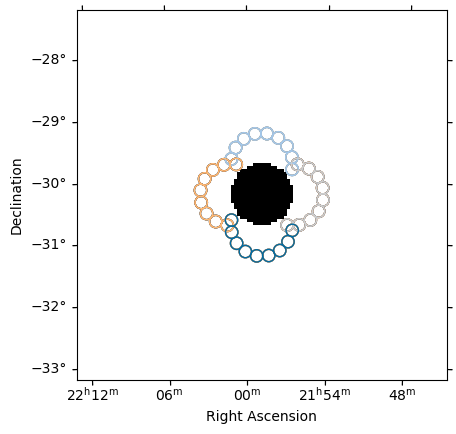

In [11]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

In [12]:
info_table = datasets.info_table(cumulative=True)
display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,83,76.11111450195312,14.047535289000427,6.888888835906982,14.500000097230076,14.500000097230076,nan,1914124.75,872973888.0,1645.9436731394428,1689.000000000005,0.050426999024630846,0.00418537338083219,0.0462416276717296,18,9,wstat,209.91629304411646,62,9.0,81.0,0.1111111119389534
stacked,458,445.4444580078125,39.5583455699664,12.555556297302246,57.100000382885334,57.100000382885334,nan,2758000.5,1531983360.0,3242.0454647149895,3378.0000000000005,0.14126883937460855,0.003872726781271716,0.1373961170057101,18,10,wstat,1617.3019420109856,113,19.0,170.99998474121094,0.111111119389534
stacked,1560,1537.3333740234375,77.22347271392506,22.666667938232422,176.40000389859077,176.40000389859077,nan,3933734.25,2047166848.0,4825.489054074511,5065.999999999999,0.32328329471243517,0.004697278904631088,0.3185860245036418,18,11,wstat,6083.113131922032,204,30.0,269.9999694824219,0.111111119389534
stacked,2363,2332.0,95.70234084675407,31.000001907348633,264.20000469252466,264.20000469252466,nan,17531772.0,2467959296.0,6386.866192122923,6756.000000000001,0.3699780031268457,0.004853710877109291,0.3651242925483725,18,11,wstat,9286.64319808576,279,41.0,368.9999694824219,0.111111119389534
stacked,3614,3570.888916015625,119.06682978163,43.11111068725586,400.20000607520336,400.20000607520336,nan,424938.5,2824567808.0,7954.743777347735,8445.000000000005,0.454320101458375,0.005419547366191842,0.44890055744903307,18,12,wstat,14309.2578151391,388,53.0,477.0,0.1111111119389534
stacked,4682,4626.33349609375,135.55013801070865,55.66666793823242,518.3000085207075,518.3000085207075,nan,3169688.75,3135240192.0,9517.102900041273,10133.000000000004,0.491956433504538,0.005849119056807825,0.48610733168322545,18,12,wstat,18521.04320150938,501,65.0,585.0,0.1111111119389534
stacked,5342,5274.77783203125,144.27994366434973,67.22222900390625,594.7000110788641,594.7000110788641,nan,10761430.0,3425071104.0,11083.773701896891,11822.0,0.48196581269841005,0.006064922544602454,0.4759008956605202,18,12,wstat,20964.146745974056,605,77.0,692.9999389648438,0.111111119389534
stacked,6017,5941.66650390625,153.17337698173878,75.33333587646484,669.500007603392,669.500007603392,nan,20959876.0,3709644544.0,12648.486569276083,13510.000000000004,0.4757090871737688,0.005955916975826495,0.4697531575310288,18,12,wstat,23623.983680091627,678,89.0,801.0,0.1111111119389534


-> A trick to round the numbers for the plotting

In [13]:
info_table_formatted = info_table.copy()
for col in info_table_formatted.colnames:
    if info_table_formatted[col].dtype.kind in ['i', 'f']:
        info_table_formatted[col] = info_table_formatted[col].round(2)
display(info_table_formatted)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,83,76.11,14.05,6.89,14.5,14.5,nan,1914124.75,872973888.0,1645.94,1689.0,0.05,0.0,0.05,18,9,wstat,209.92,62,9.0,81.0,0.11
stacked,458,445.44,39.56,12.56,57.1,57.1,nan,2758000.5,1531983360.0,3242.05,3378.0,0.14,0.0,0.14,18,10,wstat,1617.3,113,19.0,171.0,0.11
stacked,1560,1537.33,77.22,22.67,176.4,176.4,nan,3933734.25,2047166848.0,4825.49,5066.0,0.32,0.0,0.32,18,11,wstat,6083.11,204,30.0,270.0,0.11
stacked,2363,2332.0,95.7,31.0,264.2,264.2,nan,17531772.0,2467959296.0,6386.87,6756.0,0.37,0.0,0.37,18,11,wstat,9286.64,279,41.0,369.0,0.11
stacked,3614,3570.89,119.07,43.11,400.2,400.2,nan,424938.5,2824567808.0,7954.74,8445.0,0.45,0.01,0.45,18,12,wstat,14309.26,388,53.0,477.0,0.11
stacked,4682,4626.33,135.55,55.67,518.3,518.3,nan,3169688.75,3135240192.0,9517.1,10133.0,0.49,0.01,0.49,18,12,wstat,18521.04,501,65.0,585.0,0.11
stacked,5342,5274.78,144.28,67.22,594.7,594.7,nan,10761430.0,3425071104.0,11083.77,11822.0,0.48,0.01,0.48,18,12,wstat,20964.15,605,77.0,693.0,0.11
stacked,6017,5941.67,153.17,75.33,669.5,669.5,nan,20959876.0,3709644544.0,12648.49,13510.0,0.48,0.01,0.47,18,12,wstat,23623.98,678,89.0,801.0,0.11
stacked,6638,6554.56,160.84,83.44,738.9,738.9,nan,30361366.0,3998413312.0,14211.51,15199.0,0.47,0.01,0.46,18,12,wstat,26041.52,751,101.0,909.0,0.11


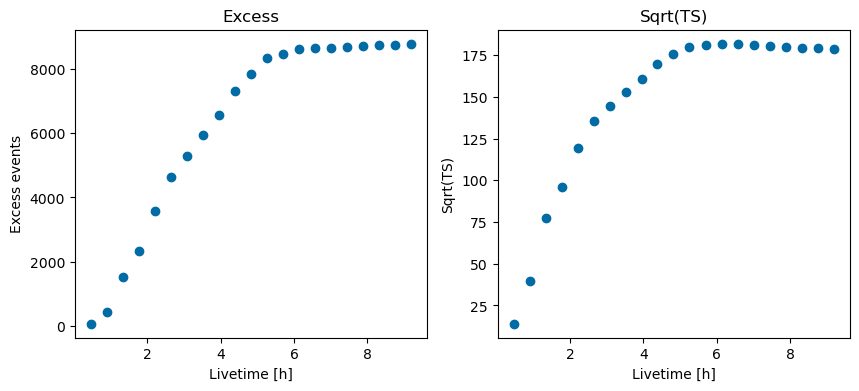

In [14]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

plt.show()

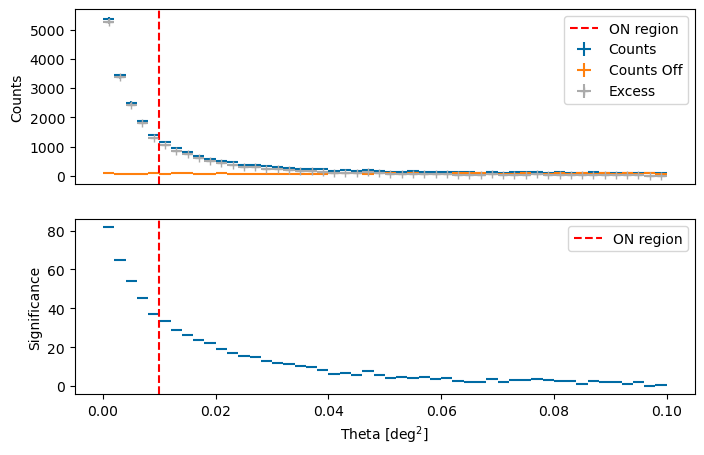

In [15]:
theta2_axis = MapAxis.from_bounds(0, 0.1, nbin=50, interp="lin", unit="deg2")
theta2_table = make_theta_squared_table(
    observations=observations,
    position=src['Position'],
    theta_squared_axis=theta2_axis,
)

on_region_radius = Angle("0.1 deg")

fig = plt.figure(figsize=(8, 5))
plot_theta_squared_table(theta2_table)
for ax in fig.get_axes():
    ax.axvline(on_region_radius.value**2, color="red", linestyle="--", label="ON region")
    ax.legend()
plt.show()

# Fit stacked spectrum

In [16]:
dataset_stack = datasets.stack_reduce(name="hess")

We will fit the overall spectrum of PKS 2155-304, under two hypotheses:
* a simple power-law
* a log-parabola

We will judge which hypotheses reperesent best the data by comparing the fit statistics.

In [17]:
reference_energy = 600. * u.Unit("GeV")

In [18]:
dataset_stack_pl = dataset_stack.copy(name="hess")

spectral_model_pl = PowerLawSpectralModel(amplitude=1e-7 * u.Unit("cm-2 s-1 TeV-1"),
                                          reference=reference_energy,
                                          index=2.
                                         )
spectral_model_pl.parameters["amplitude"].frozen = False
spectral_model_pl.parameters["amplitude"].min = 0.
spectral_model_pl.parameters["index"].frozen = False

source_pl = SkyModel(
    spectral_model=spectral_model_pl,
    name=src['Name'],
)

dataset_stack_pl.models = source_pl
print(dataset_stack_pl)

SpectrumDatasetOnOff
--------------------

  Name                            : hess 

  Total counts                    : 8980 
  Total background counts         : 203.33
  Total excess counts             : 8776.67

  Predicted counts                : 4048531.04
  Predicted background counts     : 183.08
  Predicted excess counts         : 4048347.96

  Exposure min                    : 3.86e+07 m2 s
  Exposure max                    : 9.43e+09 m2 s

  Number of total bins            : 18 
  Number of fit bins              : 12 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7979139.73

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : PKS 2155-304
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index  

In [19]:
%%time

fit_pl = Fit()
result_pl = fit_pl.run(datasets=dataset_stack_pl)

# we make a copy here to compare it later
model_best_pl = source_pl.copy(name=src['Name'])

CPU times: user 86.4 ms, sys: 1.11 ms, total: 87.5 ms
Wall time: 85 ms


/home/khelifi/MesProgrammes/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/astropy/units/quantity.py:653: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/MesProgrammes/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [20]:
model_best_pl

SkyModel(spatial_model=None, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7da8b8910a10>)temporal_model=None)

In [21]:
dataset_stack_lp = dataset_stack.copy(name="hess")

spectral_model_lp = LogParabolaSpectralModel(amplitude=1e-7 * u.Unit("cm-2 s-1 TeV-1"),
                                             reference=reference_energy,
                                             alpha=2.,
                                             beta=0.01,
                                            )
spectral_model_lp.parameters["amplitude"].frozen = False
spectral_model_lp.parameters["amplitude"].min = 0.
spectral_model_lp.parameters["alpha"].frozen = False
spectral_model_lp.parameters["beta"].frozen = False
spectral_model_lp.parameters["beta"].min = 0.

source_lp = SkyModel(
    spectral_model=spectral_model_lp,
    name=src['Name'],
)

dataset_stack_lp.models = source_lp
print(dataset_stack_lp)

SpectrumDatasetOnOff
--------------------

  Name                            : hess 

  Total counts                    : 8980 
  Total background counts         : 203.33
  Total excess counts             : 8776.67

  Predicted counts                : 3966508.71
  Predicted background counts     : 183.08
  Predicted excess counts         : 3966325.64

  Exposure min                    : 3.86e+07 m2 s
  Exposure max                    : 9.43e+09 m2 s

  Number of total bins            : 18 
  Number of fit bins              : 12 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7815154.70

  Number of models                : 1 
  Number of parameters            : 4
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : PKS 2155-304
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      ampl

In [22]:
%%time

fit_lp = Fit()
result_lp = fit_lp.run(datasets=dataset_stack_lp)

# we make a copy here to compare it later
model_best_lp = source_lp.copy(name=src['Name'])

CPU times: user 196 ms, sys: 1.17 ms, total: 197 ms
Wall time: 194 ms


In [23]:
model_best_lp

SkyModel(spatial_model=None, spectral_model=<gammapy.modeling.models.spectral.LogParabolaSpectralModel object at 0x7da8b845a9f0>)temporal_model=None)

In [24]:
def sigma_lp_vs_pl(df=1):
    ts_pl = result_pl.total_stat
    ts_lp = result_lp.total_stat
    Delta_TS = ts_pl-ts_lp
    p_value = chi2.sf(Delta_TS, df=df)
    sigma = norm.isf(0.5*p_value)  # 0.5 only for 1-sided hypothesis on curvature parameter (which is constrained positive)
    return sigma

In [25]:
sigma_lp_pl = sigma_lp_vs_pl()

criterion_lp_pl_selection = 3.0  # How many sigma to prefer LP over PL ?

if sigma_lp_pl >= criterion_lp_pl_selection:
    print(f"Log-parabola preferred over a power-law at {sigma_lp_pl:.2f} sigmas.")
    result = result_lp
    fit = fit_lp
    dataset_stack = dataset_stack_lp.copy(name="hess")
    model_best = source_lp.copy(name=src['Name'])
else:
    print(f"Log-parabola *not* preferred over a power-law (Delta TS(log-parabola vs power-law)={sigma_lp_pl:.2f} sigmas).")
    result = result_pl
    fit = fit_pl
    dataset_stack = dataset_stack_pl.copy(name="hess")
    model_best = source_pl.copy(name=src['Name'])
    
source_model = SkyModel(
    spectral_model=model_best.spectral_model,
    name=src['Name'],
)
dataset_stack.models = source_model

Log-parabola preferred over a power-law at 6.86 sigmas.


**TRICK**: We could also use `Gammapy` built-in functionalities to compare nested spectral models in an easier way:

In [26]:
model_comparison = select_nested_models(
    datasets=dataset_stack,
    parameters=[dataset_stack.models[src['Name']].spectral_model.beta],
    null_values=[0.],
)

In [27]:
print(model_comparison)
print(f"The log-parabola model describes the dataset better than the power-law model at a {np.sqrt(model_comparison['ts']):.2f} sigmas confidence level.")

{'ts': np.float64(47.11064503268625), 'fit_results': <gammapy.modeling.fit.FitResult object at 0x7da7f0e45a60>, 'fit_results_null': <gammapy.modeling.fit.FitResult object at 0x7da7f0dbeb10>}
The log-parabola model describes the dataset better than the power-law model at a 6.86 sigmas confidence level.


# Compute flux points

In [28]:
n_jobs = 8
energy_edges = resample_energy_edges(dataset_stack, conditions={'sqrt_ts_min': 2.})

fpe = FluxPointsEstimator(
    energy_edges=energy_edges,
    source=src['Name'],
    selection_optional=["errn-errp", "ul", "scan"],
    fit=fit,
    n_jobs=n_jobs,     # TRICK : one can have a multi-core processing
)
flux_points = fpe.run([dataset_stack])

Energy bins:   0%|          | 0/6 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Reoptimize = False ignored for iminuit backend


Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

Scan values:   0%|          | 0/11 [00:00<?, ?it/s]

# Spectral energy distribution

We will produce an SED with the best-fit model and results.

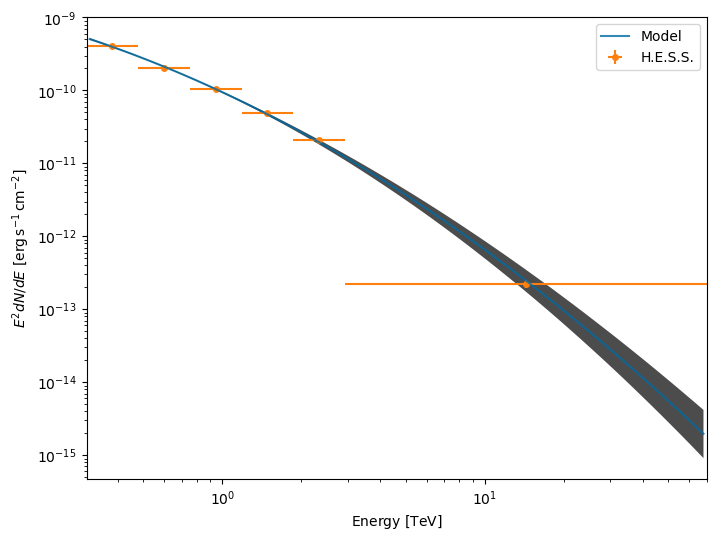

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_kwargs = {
    "energy_bounds": [energy_edges[0], energy_edges[-1]],
    "sed_type": "e2dnde",  # "dnde"
    "yunits": u.Unit("erg cm-2 s-1"),  # u.Unit("cm-2 s-1 TeV-1")  # TRICK : this is how one can change the units for final plots
    "ax": ax,
}

spec = dataset_stack.models[src['Name']].spectral_model

# plot best-fit model
spec.plot(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    label="Model",
    alpha=0.8,
    zorder=3,
)
spec.plot_error(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    alpha=0.7,
    zorder=2,
)

# plot the fluc points
flux_points.plot(ax=plot_kwargs['ax'],
             sed_type=plot_kwargs['sed_type'],
             label="H.E.S.S.")

ylabel = ax.get_ylabel()
ax.set_ylabel(ylabel.replace('e2dnde', '$E^2 dN/dE$'))   # TRICK : this is how one can change a title of a plot
ax.legend()
plt.show()

# Systematics study

Now, we will define a **custom spectral model** by introducing a nuisance parameter on the energy scale, and study the systematic effet of a bias on the final fitted parameters.

In [30]:
# Define some custom biased spectral models
#
# See https://github.com/bkhelifi/CTAO-CTAC_Meeting_Granada_2023/blob/main/Crab_simulations_systematic_errors_Solution.ipynb

class BiasedPowerLawSpectralModel(SpectralModel):
    tag = "BiasedPowerLawSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0)
    index = Parameter("index", 2.5, min=0)
    reference = Parameter("reference", "1 TeV", frozen=True)
    bias = Parameter("bias", 1., min=0.)
        
    @staticmethod
    def evaluate(energy, amplitude, index, reference, bias):
        energy = bias.value * energy
        pwl = PowerLawSpectralModel.evaluate(
            energy=energy,
            index=index,
            amplitude=amplitude,
            reference=reference,
        )
        return pwl

class BiasedLogParabolaSpectralModel(SpectralModel):
    tag = "BiasedLogParabolaSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0)
    alpha = Parameter("alpha", 2.5, min=0)
    beta = Parameter("beta", 0.5)
    reference = Parameter("reference", "1 TeV", frozen=True)
    bias = Parameter("bias", 1., min=0.)
        
    @staticmethod
    def evaluate(energy, amplitude, alpha, beta, reference, bias):
        energy = bias.value * energy
        logpwl = LogParabolaSpectralModel.evaluate(
            energy=energy,
            alpha=alpha,
            beta=beta,
            amplitude=amplitude,
            reference=reference,
        )
        return logpwl

In [31]:
# Define the biased model, based on the best model shape obtained above (PL or LP)

if sigma_lp_pl >= criterion_lp_pl_selection:
    spectral_model_biased = BiasedLogParabolaSpectralModel(
        amplitude=model_best.spectral_model.amplitude,
        reference=model_best.spectral_model.reference,
        alpha=model_best.spectral_model.alpha,
        beta=model_best.spectral_model.beta,
    )
    spectral_model_biased.parameters["alpha"].frozen = False
    spectral_model_biased.parameters["beta"].frozen = False
    spectral_model_biased.parameters["beta"].min = 0.
else:
    spectral_model_biased = BiasedPowerLawSpectralModel(
        amplitude=model_best.spectral_model.amplitude,
        reference=model_best.spectral_model.reference,
        index=model_best.spectral_model.index,
    )
    spectral_model_biased.parameters["index"].frozen = False

spectral_model_biased.parameters["amplitude"].frozen = False
spectral_model_biased.parameters["amplitude"].min = 0.

biased_model = SkyModel(
    spectral_model=spectral_model_biased,
    name=f"biased_{src['Name']}",
)
print(biased_model)

SkyModel

  Name                      : biased_PKS 2155-304
  Datasets names            : None
  Spectral model type       : BiasedLogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.67e-10   +/- 6.0e-12 1 / (TeV s cm2)
    alpha                         :      3.472   +/-    0.03             
    beta                          :      0.206   +/-    0.03             
    reference             (frozen):    600.000       GeV         
    bias                          :      1.000   +/-    0.00             




In [32]:
%%time

# Definition of reference dataset
reference_dataset = dataset_stack.copy(name="hess")

# Fake counts taking bias into account with a mean energy bias of 10%
simulated_biased_datasets = []
n_sim = 1000
energy_bias = 10./100.

# Fit the unbiased model
results_biased = []
fit_biased = Fit()
    
for i in tqdm(range(n_sim)):
    ds = reference_dataset
    # Randomize random bias
    biased_model.spectral_model.bias.value = np.random.normal(loc=1.0, scale=energy_bias)
    biased_model.spectral_model.bias.frozen = True
    
    # Set the model on the ON-OFF dataset using the *biased* model
    ds.models = [biased_model]

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', RuntimeWarning)
        ds.fake(random_state='random-seed', npred_background=reference_dataset.background)  # SpectrumDatasetOnOff.fake() takes 2 arguments
    
    # We use a copy of the best (PL or LP) *unbiased* model
    ds.models = [source_model.copy(name=src['Name'])]
    
    fit_result = fit_biased.run([ds])

    if fit_result.success:
        par_dict = {}
        for par in fit_result.parameters.free_parameters:
            par_dict[par.name] = par.quantity
        results_biased.append(par_dict)
        
    simulated_biased_datasets.append(ds)

 34%|████████████████████████████▉                                                         | 336/1000 [00:27<00:52, 12.69it/s]/home/khelifi/MesProgrammes/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/astropy/units/quantity.py:653: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/MesProgrammes/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/MesProgrammes/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/astropy/units/quantity.py:653: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/MesProgrammes/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/gammapy/datasets/utils.py:71: RuntimeWarning: invalid value encountered in mat

CPU times: user 1min 23s, sys: 1.15 s, total: 1min 24s
Wall time: 1min 23s


In [33]:
fitted_params_with_energy_bias = Table(results_biased).to_pandas()   # TRICK: pandas table are very usefull
biased_mean = fitted_params_with_energy_bias.mean()
biased_uncertainty = fitted_params_with_energy_bias.std()

In [34]:
for par in result.models[src['Name']].spectral_model.parameters.free_parameters:
    statistic_uncertainty = par.error * par.unit
    total_uncertainty = biased_uncertainty[par.name] * par.unit
    systematic_uncertainty = np.sqrt(np.abs(total_uncertainty**2 - statistic_uncertainty**2))
    print(f"{par.name} : {par.quantity.value:.3e} +/-\t"
          f" {statistic_uncertainty.value:.3e} (stat.) +/-\t"
          f" {systematic_uncertainty.value:.3e} (syst.) {par.quantity.unit}")

amplitude : 3.666e-10 +/-	 5.994e-12 (stat.) +/-	 1.432e-10 (syst.) 1 / (TeV s cm2)
alpha : 3.472e+00 +/-	 2.587e-02 (stat.) +/-	 4.020e-02 (syst.) 
beta : 2.064e-01 +/-	 3.370e-02 (stat.) +/-	 1.433e-02 (syst.) 


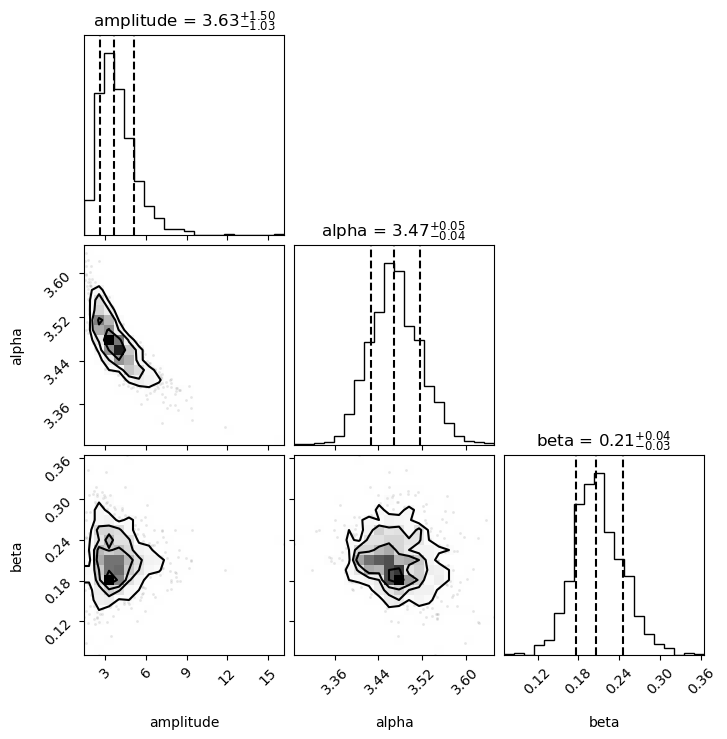

In [35]:
fitted_params_with_energy_bias['amplitude'] *= 1e10

figure = corner.corner(fitted_params_with_energy_bias,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True,
                       title_kwargs={"fontsize": 12})

The warning message is interesting... Try to install the mention library to redo the corner plot

In [37]:
#XXX

Let's plot the resulting SED with the effect of the uncertainties on the energy scale:

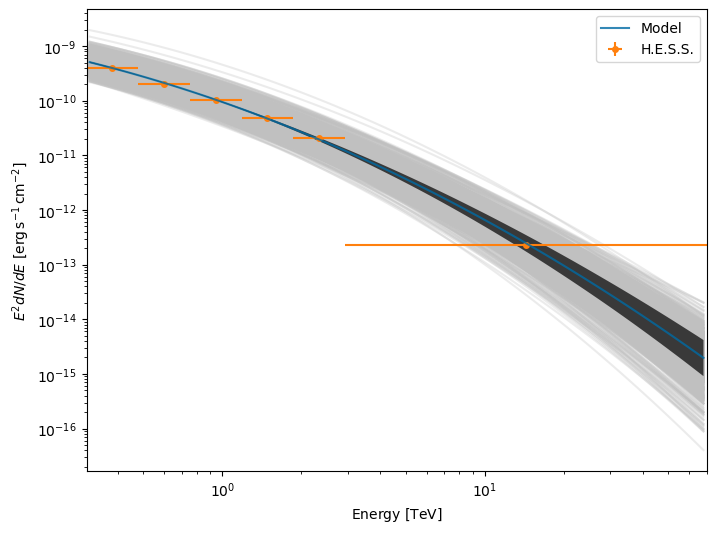

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_kwargs = {
    "energy_bounds": [energy_edges[0], energy_edges[-1]],
    "sed_type": "e2dnde",
    "yunits": u.Unit("erg cm-2 s-1"),
    "ax": ax,
}

spec = dataset_stack.models[src['Name']].spectral_model

# plot best-fit model
spec.plot(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    label="Model",
    alpha=0.8,
    zorder=3,
)
spec.plot_error(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    alpha=0.7,
    zorder=2,
)

# plot all fitted biased models
for i, result_biased in enumerate(results_biased):
    if sigma_lp_pl >= criterion_lp_pl_selection:
        spec_biased = LogParabolaSpectralModel(
            amplitude=result_biased["amplitude"],
            reference=reference_energy,
            alpha=result_biased["alpha"],
            beta=result_biased["beta"],
        )
    else:
        spec_biased = PowerLawSpectralModel(
            amplitude=result_biased["amplitude"],
            reference=reference_energy,
            index=result_biased["index"],
        )

    spec_biased.plot(
        ax=plot_kwargs['ax'],
        energy_bounds=plot_kwargs['energy_bounds'],
        sed_type=plot_kwargs['sed_type'],
        # label="Biased model",
        alpha=0.3,
        color='silver',
        zorder=1,
    )

flux_points.plot(ax=plot_kwargs['ax'],
             sed_type=plot_kwargs['sed_type'],
             label="H.E.S.S.")

ylabel = ax.get_ylabel()
ax.set_ylabel(ylabel.replace('e2dnde', '$E^2 dN/dE$'))
ax.legend()
plt.show()